In [1]:
from config import EXPER_PATH, MODEL_PATH
import sys
sys.path.append(MODEL_PATH)
from model.dataset.hpatches import HpatchesDataset

In [2]:
import numpy as np
import torch

from model.export_local import export_loader

from evaluation.utils.keypoints import keypoints_warp_2D
from evaluation.keypoint_detectors import compute_correctness


from model.hfnet import HFNet
from utils import plot_images

from torch.utils.data import DataLoader

In [3]:
# Load dataset
dataset = HpatchesDataset(alteration='all', make_pairs=True, shuffle=True)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

config = {
        'local':{
            'nms_radius':8,
            'detector_threshold': 0.1,
            'num_keypoints': 1000,
        },
        'do_ratio_test': True,
        'correct_match_thresh': 3,
        'correct_H_thresh': 3,
        'num_features': 500,
        # 'do_nms': True,
        # 'nms_thresh': 4,
        # 'remove_borders': 4,
    }

config_model= {
    'image_channels':1,
    # 'loss_weights': 'uncertainties',
    'loss_weights':{
        'global':1,
        'local':1,
        'detector':1
    },
    'local_head': {
        'scale':2,
        'descriptor_dim': 128,
        'detector_grid': 8,
        'input_channels': 96
    },
    'global_head': {
        'n_clusters': 32,
        'intermediate_proj': 0,
        'dimensionality_reduction': 4096
    }
}

model = HFNet(config_model, width_mult=0.75)
model_path = r'/media/tupv8/32f7b466-e4d4-4f6f-b2aa-1e5a8ce7663c/vinai/hfnet_reproduce/hfnet_silk/results/last_model.pth'
checkpoint = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(checkpoint,strict=False)



/home/tupv8/miniconda3/envs/reproduce/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


<All keys matched successfully>

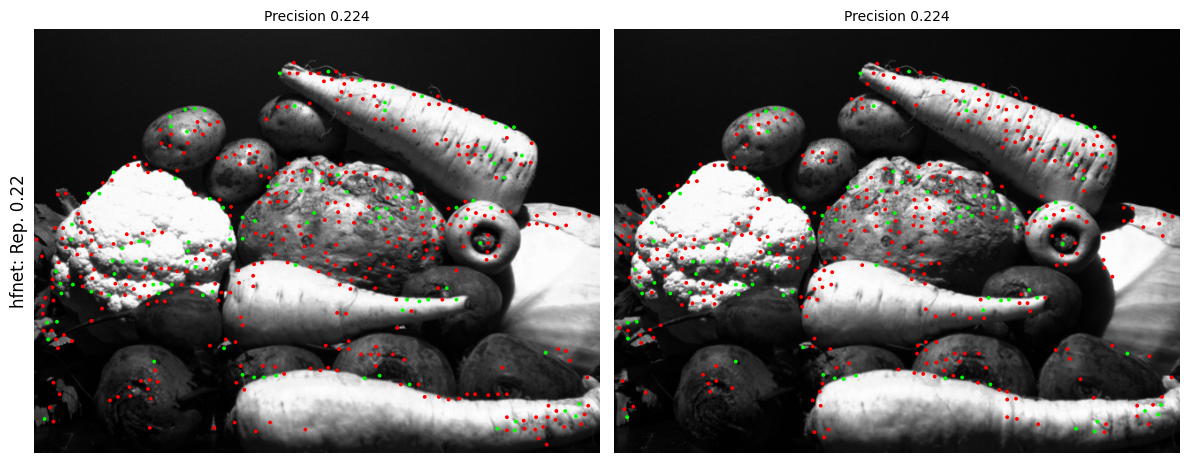

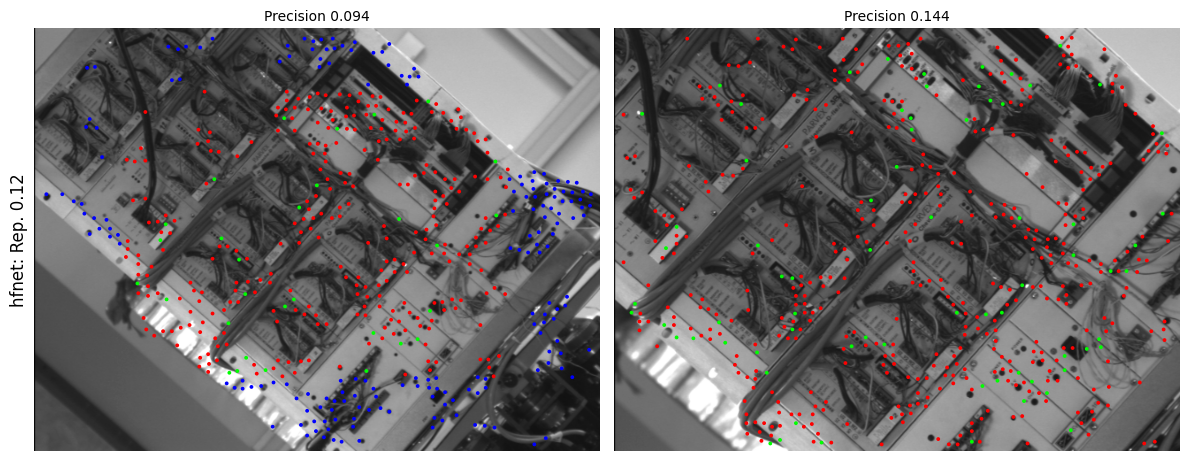

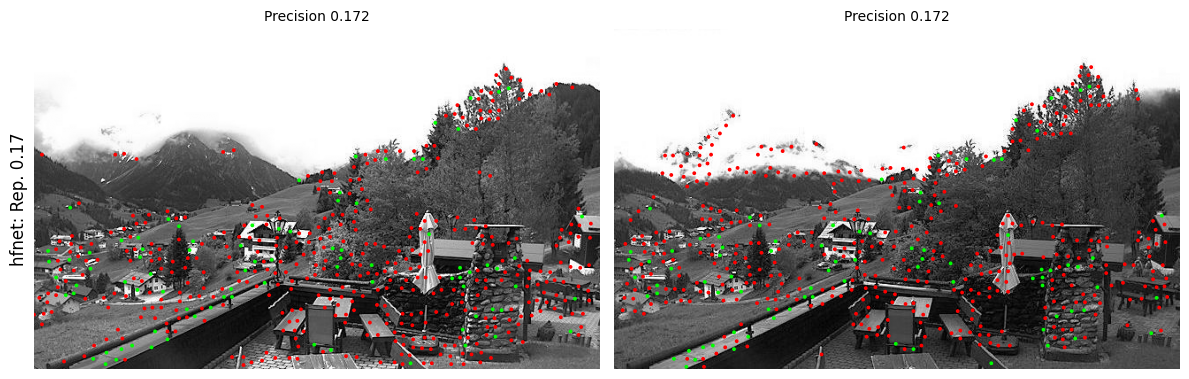

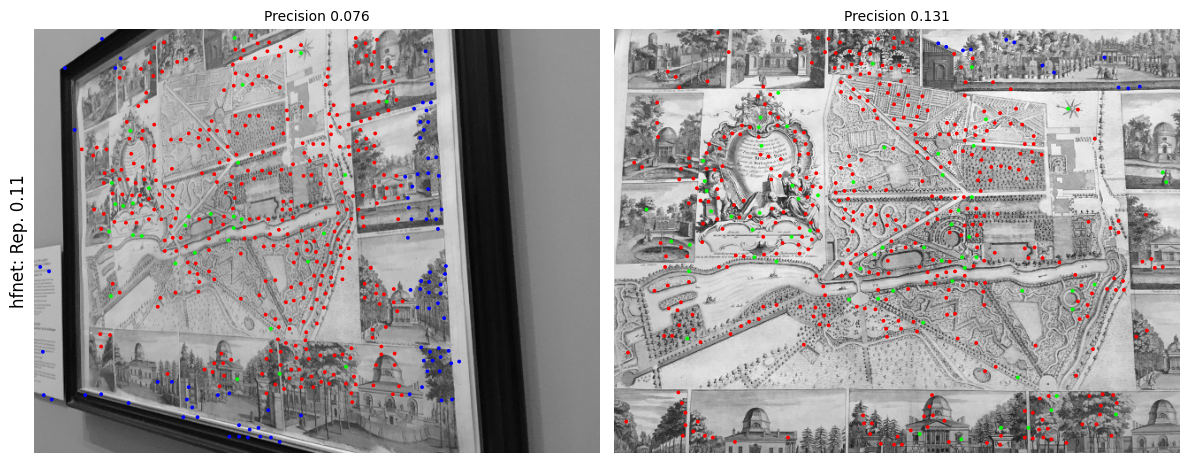

In [4]:
for i,data in enumerate(dataloader):
    if i>5 and i<10:
        shape1 = data['image'].detach().cpu().numpy().shape[-2:][::-1]  
        shape2 = data['image2'].detach().cpu().numpy().shape[-2:][::-1]  

        pred1 = export_loader(model(data['image'].unsqueeze(0)), config, 
                              data['image'].squeeze(0))

        pred2 = export_loader(model(data['image2'].unsqueeze(0)), config, 
                              data['image2'].squeeze(0))
        
        kpts1_w, vis1 = keypoints_warp_2D(
            pred1['keypoints'], np.linalg.inv(data['homography'][0]), shape2)
    
        kpts2_w, vis2 = keypoints_warp_2D(
            pred2['keypoints'], data['homography'][0], shape1)

        correct1, correct2, dist1, dist2 = compute_correctness(
                pred1['keypoints'], pred2['keypoints'], kpts1_w, kpts2_w, 3)

        rep = (correct1[vis1].sum() + correct2[vis2].sum()) / (vis1.sum() + vis2.sum())
        
        colormap = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        colors1 = colormap[(vis1 & correct1) + (~vis1)*2]
        colors1 = list(map(tuple, colors1))
        colors2 = colormap[(vis2 & correct2) + (~vis2)*2]
        colors2 = list(map(tuple, colors2))

        plot_images(
                [data['image'].squeeze(0), data['image2'].squeeze(0)], ylabel=f'hfnet: Rep. {rep:.2f}', labelfont=12, dpi=100,
                titles=[f'Precision {correct1[vis1].mean():.3f}', f'Precision {correct2[vis2].mean():.3f}'],
                keypoints=[pred1['keypoints'],pred2['keypoints']], keypoint_colors=[colors1, colors2]
            )
        
